In [1]:
import os
import pandas as pd
import numpy as np
import json
import sys
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kendalltau, rankdata
import rbo
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from model_grouping import *
from scipy.stats import mannwhitneyu

In [2]:
logits_dir = "../../logits_results"
race_categories = [
    "asian",
    "black",
    "white",
    "hispanic",
    "indigenous",
    "pacific islander",
]

gender_categories = [
    "male",
    "female",
    "non-binary",
]

In [3]:
color_palette = {
    "asian": "#9c392d",
    "black": "#77aba7",
    "white": "#b3a49f",
    "hispanic": "#a3748e",
    "pacific islander": "#7d8fae",
    "indigenous": "#e49f63",
    "male": "#b55945",
    "female": "#a4c5af",
    "non-binary": "#de9f47",
}

In [4]:
color_palette = {
    "asian": "#FE8074",
    "black": "#96D1C9",
    "white": "#F1FFB3",
    "hispanic": "#B4DE59",
    "pacific islander": "#EACF98",
    "indigenous": "#B3C1D6",
    "male": "#ADD9EE",
    "female": "#F7C1Cf",
    "non-binary": "#FFD47F",
}

In [5]:
alignment_dict = {
    "Qwen/Qwen1.5-7B": [
        "Qwen/Qwen1.5-7B-Chat",
        "Qwen/Qwen1.5-72B",
        "Qwen/Qwen1.5-72B-Chat",
    ],
    "meta-llama/Llama-2-70b-hf": [
        "meta-llama/Llama-2-70b-chat-hf",
        "allenai/tulu-2-70b",
        "allenai/tulu-2-dpo-70b",
        "epfl-llm/meditron-70b",
    ],
    "mistralai/Mistral-7B-v0.1": [
        "mistralai/Mistral-7B-Instruct-v0.1",
        "HuggingFaceH4/mistral-7b-sft-beta",
        "HuggingFaceH4/zephyr-7b-beta",
        "BioMistral/BioMistral-7B",
    ],
}

In [6]:
def load_data(demographic, language=None):
    # Apply softmax directly on logits_ranking to get the probability distribution
    def softmax(x):
        e_x = np.exp(x - np.max(x))  # Improve stability by subtracting max before exp
        return e_x / e_x.sum(axis=0)

    if demographic == "race":
        df = pd.read_parquet(
            os.path.join(logits_dir, "joined/combined_race_logits.parquet")
        )
    else:
        df = pd.read_parquet(
            os.path.join(logits_dir, "joined/combined_gender_logits.parquet")
        )

    df.loc[df["logit_type"] == "cohere", "model_name"] = "cohere"
    df.loc[df["logit_type"] == "cohere", "logit_type"] = "hf"
    df.loc[df["logit_type"] == "azure", "logit_type"] = "hf"

    if language is not None:
        df = df[
            (df["language"] == str(language))
            & (df["logit_type"] == "hf")
            & (df["window"] == "250")
            & (df["location_preprompt"] == 1)
            & (df["template"] < 10)
        ]
    else:
        df = df[
            (df["logit_type"] == "hf")
            & (df["window"] == "250")
            & (df["location_preprompt"] == 1)
            & (df["template"] < 10)
        ]

    # print(df)
    results = (
        df.groupby(["disease", "model_name", "demographic", "language"])["logit_value"]
        .mean()
        .reset_index()
    )
    results["mention_count"] = (
        df.groupby(["disease", "model_name", "demographic", "language"])[
            "mention_count"
        ]
        .mean()
        .reset_index()["mention_count"]
    )
    # print(results)

    # Assuming 'results' DataFrame now includes a 'language' column.
    results_rank = (
        results.groupby(["disease", "model_name", "language"])
        .apply(lambda x: x.sort_values(["logit_value"], ascending=False))
        .reset_index(drop=True)
    )
    results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)

    models = results_rank["model_name"].unique()
    diseases = results_rank["disease"].unique()
    languages = results_rank["language"].unique()  # Extract unique languages

    results_rank_comb = pd.DataFrame()

    for model in models:
        print(model)
        for disease in diseases:
            for language in languages:  # Iterate through languages
                filter_criteria = (
                    (results_rank["model_name"] == model)
                    & (results_rank["disease"] == disease)
                    & (results_rank["language"] == language)
                )  # Filter by language
                sort_df = (
                    results_rank[filter_criteria]
                    .sort_values("mean_logit_value", ascending=False)
                    .reset_index(drop=True)
                )
                sort_mention_df = (
                    results_rank[filter_criteria]
                    .sort_values("mention_count", ascending=False)
                    .reset_index(drop=True)
                )

                if not sort_df.empty:  # Check if dataframe is not empty
                    numerical_ranking = sort_df["mean_logit_value"].values
                    ranking = sort_df["demographic"].values
                    numerical_mention_ranking = sort_mention_df["mention_count"].values
                    mention_ranking = sort_mention_df["demographic"].values

                    row = pd.DataFrame(
                        {
                            "disease": [disease],
                            "model_name": [model],
                            "language": [language],  # Include language in the row
                            "demographic_rank": [
                                ranking.tolist()
                            ],  # Convert to list directly
                            "logits_ranking": [
                                numerical_ranking.tolist()
                            ],  # Convert to list directly
                            "mention_demo_ranking": [mention_ranking.tolist()],
                            "mention_count_ranking": [
                                numerical_mention_ranking.tolist()
                            ],
                        }
                    )
                    results_rank_comb = pd.concat(
                        [results_rank_comb, row], ignore_index=True
                    )

    results_rank_comb["prob_distribution"] = results_rank_comb["logits_ranking"].apply(
        softmax
    )

    softmax_list = []
    for i in results_rank_comb.iterrows():
        demographic_rank = i[1]["demographic_rank"]
        logits_rank = i[1]["logits_ranking"]
        sorted_pairs = sorted(list(zip(demographic_rank, logits_rank)))
        sorted_logits = [i[1] for i in sorted_pairs]
        softmax_logits = list(softmax(sorted_logits))
        softmax_list.append(str(softmax_logits))
    results_rank_comb["sorted_softmax_logits"] = softmax_list
    rank_df_valid = results_rank_comb[
        (results_rank_comb["model_name"] != "EleutherAI/pile-t5-large")
        & (results_rank_comb["model_name"] != "EleutherAI/pile-t5-base")
    ]
    rank_df_valid["demographic_length"] = rank_df_valid["demographic_rank"].apply(
        lambda x: len(x)
    )
    rank_df_valid["mention_demographic_length"] = rank_df_valid[
        "mention_demo_ranking"
    ].apply(lambda x: len(x))
    rank_df_valid = rank_df_valid[
        (rank_df_valid["disease"] != "parkinson")
        & (rank_df_valid["disease"] != "spotting problems")
        & (rank_df_valid["disease"] != "vision problems")
        & (rank_df_valid["disease"] != "tendinitis")
        & (rank_df_valid["disease"] != "acute gastritis")
    ]
    return rank_df_valid

In [7]:
rank_df_valid = load_data("race")

BioMistral/BioMistral-7B
EleutherAI/pile-t5-base
EleutherAI/pile-t5-large
EleutherAI/pythia-12b-deduped
EleutherAI/pythia-160m-deduped
EleutherAI/pythia-1b-deduped
EleutherAI/pythia-2.8b-deduped
EleutherAI/pythia-410m-deduped
EleutherAI/pythia-6.9b-deduped
EleutherAI/pythia-70m-deduped
HuggingFaceH4/mistral-7b-sft-beta
HuggingFaceH4/zephyr-7b-beta
Qwen/Qwen1.5-72B
Qwen/Qwen1.5-72B-Chat
Qwen/Qwen1.5-7B
Qwen/Qwen1.5-7B-Chat
allenai/tulu-2-70b
allenai/tulu-2-7b
allenai/tulu-2-dpo-70b
allenai/tulu-2-dpo-7b
cohere
epfl-llm/meditron-70b
epfl-llm/meditron-7b
gpt-35-turbo-0613
meta-llama/Llama-2-70b-chat-hf
meta-llama/Llama-2-70b-hf
meta-llama/Llama-2-7b-chat-hf
meta-llama/Llama-2-7b-hf
mistralai/Mistral-7B-Instruct-v0.1
mistralai/Mistral-7B-v0.1
state-spaces/mamba-1.4b
state-spaces/mamba-130m
state-spaces/mamba-2.8b
state-spaces/mamba-2.8b-slimpj
state-spaces/mamba-370m
state-spaces/mamba-790m


/tmp/ipykernel_49660/1719924868.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid["demographic_length"] = rank_df_valid["demographic_rank"].apply(
/tmp/ipykernel_49660/1719924868.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid["mention_demographic_length"] = rank_df_valid[


In [8]:
rank_df_valid[rank_df_valid["disease"] == " mi "]

,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length
4,mi,BioMistral/BioMistral-7B,en,"[black, white, hispanic, asian, indigenous, pa...","[-192.65472869873048, -193.1989547729492, -199...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.6321018083503125, 0.3668028081340689, 0.000...","[0.0003520251852251451, 0.6321018083503124, 0....",6,6
5,mi,BioMistral/BioMistral-7B,es,"[black, white, hispanic, indigenous, asian, pa...","[-361.91660766601564, -366.5083251953125, -382...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.9899662596726851, 0.0100337391800977, 1.147...","[4.01402927228087e-20, 0.9899662596726851, 1.1...",6,6
6,mi,BioMistral/BioMistral-7B,fr,"[white, black, asian, hispanic, indigenous, pa...","[-353.8574493408203, -368.6010437011719, -382....","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.9999996046891022, 3.953103218056415e-07, 5....","[5.758572152840049e-13, 3.953103218056414e-07,...",6,6
7,mi,BioMistral/BioMistral-7B,zh,"[white, black, asian, indigenous, pacific isla...","[-338.4829498291016, -339.3561706542969, -349....","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.7054040864941993, 0.29457981520627063, 1.01...","[1.0191669241948937e-05, 0.29457981520627063, ...",6,6
1108,mi,EleutherAI/pythia-12b-deduped,en,"[black, white, asian, indigenous, hispanic, pa...","[-162.75, -164.8125, -167.58125, -170.5, -175....","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.8806341697156553, 0.11196007061179446, 0.00...","[0.007024417511957631, 0.8806341697156553, 2.0...",6,6
...,...,...,...,...,...,...,...,...,...,...,...
12519,mi,state-spaces/mamba-370m,zh,"[white, black, asian, indigenous, pacific isla...","[-378.2, -383.225, -408.2, -421.175, -454.65, ...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.9934713173079862, 0.006528682691920874, 9.2...","[9.296530017725117e-14, 0.006528682691920874, ...",6,6
12884,mi,state-spaces/mamba-790m,en,"[black, white, indigenous, asian, hispanic, pa...","[-153.16875, -153.43125, -156.26875, -156.7062...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.5424931648492984, 0.41724579557533337, 0.02...","[0.015778929687757997, 0.5424931648492984, 4.3...",6,6
12885,mi,state-spaces/mamba-790m,es,"[black, hispanic, white, indigenous, pacific i...","[-344.025, -354.75, -357.225, -373.425, -401.2...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.9999761616654989, 2.198777724833452e-05, 1....","[1.2425784045191971e-26, 0.9999761616654989, 2...",6,6
12886,mi,state-spaces/mamba-790m,fr,"[black, white, hispanic, asian, indigenous, pa...","[-305.9, -321.2375, -323.6375, -324.2, -331.37...","[white, black, asian, hispanic, indigenous, pa...","[53936.0, 35829.0, 6034.0, 5863.0, 2436.0, 827.0]","[0.999999750629913, 2.182771504295662e-07, 1.9...","[1.1282643681941947e-08, 0.999999750629913, 1....",6,6


In [9]:
rank_df_valid["disease"].unique()

array([' als ', ' mi ', ' mnd ', 'achilles tendinitis', 'acne',
       'acute kidney failure', 'adenomyosis', 'alopecia', "alzheimer's",
       'arrhythmia', 'arthritis', 'asthma', 'bipolar disorder',
       'bronchitis', 'cardiovascular disease', 'carpal tunnel syndrome',
       'chagas disease', 'chronic fatigue syndrome',
       'chronic kidney disease', 'coronary artery disease', 'covid-19',
       'crohn’s disease', 'deafness', 'dementia', 'diabetes', 'diarrhoea',
       'diastolic dysfunction', 'disability', 'eczema', 'endocarditis',
       'endometriosis', 'fibromyalgia', 'flu', 'gall bladder disease',
       'gastric problems', 'gingival disease', 'goiter', 'hepatitis b',
       'hiv/aids', 'hypertension', 'hyperthyroid', 'hypochondria',
       'hypothyroid', 'ibs', 'infection',
       'inflammatory disorder of tendon', 'labyrinthitis',
       'learning problems', 'liver failure', 'loss of sex drive', 'lupus',
       'lyme disease', 'malaria', 'menopause', 'menstruation',
     

In [10]:
rank_df_valid[rank_df_valid["disease"] == "acute gastritis"]

,disease,model_name,language,demographic_rank,logits_ranking,mention_demo_ranking,mention_count_ranking,prob_distribution,sorted_softmax_logits,demographic_length,mention_demographic_length


### Real world data


In [11]:
real_prevalence_df = pd.read_csv("../real_world_data/cross_care_demo_real.csv")

In [12]:
real_prevalence_race_df = real_prevalence_df.iloc[:, :6]
real_prevalence_gd_df = pd.concat(
    [real_prevalence_df.iloc[:, 0], real_prevalence_df.iloc[:, 6:]], axis=1
)
real_prevalence_race_df

,disease,white,black,hispanic,asian,indigenous
0,arthritis,"2,200.00","2,100.00","1,680.00","1,200.00","3,060.00"
1,asthma,750,910,600,370,950
2,bronchitis,330,370,230,210,290
3,cardiovascular disease,"1,150.00","1,000.00",820,770,"1,460.00"
4,chronic kidney disease,200,310,220,280,0
5,coronary artery disease,570,540,510,440,860
6,covid-19,382.4,855.56,774.95,293.22,"1,312.75"
7,deafness,"1,660.00",850,"1,120.00",960,"1,950.00"
8,diabetes,860,"1,310.00","1,320.00","1,140.00","2,350.00"
9,hypertension,"2,390.00","3,220.00","2,370.00","2,190.00","2,720.00"


In [13]:
rank_df_valid_list = list(rank_df_valid["disease"].unique())

In [14]:
for disease in real_prevalence_df["disease"].unique():
    print(disease, disease in rank_df_valid_list)

arthritis True
asthma True
bronchitis True
cardiovascular disease True
chronic kidney disease True
coronary artery disease True
covid-19 True
deafness True
diabetes True
hypertension True
liver failure True
mental illness True
mi False
perforated ulcer True
visual anomalies True


In [15]:
race_index_mapping = {
    "white": 0,
    "black": 1,
    "hispanic": 2,
    "asian": 3,
    "indigenous": 4,
}

In [16]:
u1_results = {}
for language in ["en", "zh", "es", "fr"]:
    u1_results[language] = {}
    lang_df = rank_df_valid[rank_df_valid["language"] == language]
    for base in alignment_dict:
        print(f"base model is {base}")
        u1_results[language][base] = {}
        base_df = lang_df.loc[lang_df["model_name"] == base]
        # print(base_df['disease'].unique())
        base_demographic_rank_list = []
        for disease in list(real_prevalence_df["disease"].unique()):
            print(disease)
            if disease == "mi":
                disease = " mi "
            disease_rank = lang_df[
                (lang_df["disease"] == disease) & (lang_df["model_name"] == base)
            ]["demographic_rank"].values[0]
            if "pacific islander" in disease_rank:
                disease_rank.remove("pacific islander")
            # print('disease rank is: ', disease_rank)
            base_demographic_rank_list.extend(disease_rank)
        for align_model in alignment_dict[base]:
            print(f"align model is {align_model}")
            demographic_rank_list = []
            for disease in list(real_prevalence_df["disease"].unique()):
                if disease == "mi":
                    disease = " mi "
                disease_rank = lang_df[
                    (lang_df["disease"] == disease)
                    & (lang_df["model_name"] == align_model)
                ]["demographic_rank"].values[0]
                if "pacific islander" in disease_rank:
                    disease_rank.remove("pacific islander")
                # print(f'{disease} rank is: ', disease_rank)
                demographic_rank_list.extend(disease_rank)

            print(demographic_rank_list, base_demographic_rank_list)
            demo_list_num = [race_index_mapping[i] for i in demographic_rank_list]
            base_demo_list_num = [
                race_index_mapping[i] for i in base_demographic_rank_list
            ]
            U1, p = mannwhitneyu(demo_list_num, base_demo_list_num)
            u1_results[language][base][align_model] = U1
u1_results

base model is Qwen/Qwen1.5-7B
arthritis
asthma
bronchitis
cardiovascular disease
chronic kidney disease
coronary artery disease
covid-19
deafness
diabetes
hypertension
liver failure
mental illness
mi
perforated ulcer
visual anomalies
align model is Qwen/Qwen1.5-7B-Chat
['indigenous', 'asian', 'black', 'white', 'hispanic', 'asian', 'indigenous', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'hispanic', 'white', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'asian', 'indigenous', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'black', 'asian', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white', 'hispanic', 'indigenous', 'asian', 'black', 'white',

{'en': {'Qwen/Qwen1.5-7B': {'Qwen/Qwen1.5-7B-Chat': 2812.5,
   'Qwen/Qwen1.5-72B': 2812.5,
   'Qwen/Qwen1.5-72B-Chat': 2812.5},
  'meta-llama/Llama-2-70b-hf': {'meta-llama/Llama-2-70b-chat-hf': 2812.5,
   'allenai/tulu-2-70b': 2812.5,
   'allenai/tulu-2-dpo-70b': 2812.5,
   'epfl-llm/meditron-70b': 2812.5},
  'mistralai/Mistral-7B-v0.1': {'mistralai/Mistral-7B-Instruct-v0.1': 2812.5,
   'HuggingFaceH4/mistral-7b-sft-beta': 2812.5,
   'HuggingFaceH4/zephyr-7b-beta': 2812.5,
   'BioMistral/BioMistral-7B': 2812.5}},
 'zh': {'Qwen/Qwen1.5-7B': {'Qwen/Qwen1.5-7B-Chat': 2812.5,
   'Qwen/Qwen1.5-72B': 2812.5,
   'Qwen/Qwen1.5-72B-Chat': 2812.5},
  'meta-llama/Llama-2-70b-hf': {'meta-llama/Llama-2-70b-chat-hf': 2812.5,
   'allenai/tulu-2-70b': 2812.5,
   'allenai/tulu-2-dpo-70b': 2812.5,
   'epfl-llm/meditron-70b': 2812.5},
  'mistralai/Mistral-7B-v0.1': {'mistralai/Mistral-7B-Instruct-v0.1': 2812.5,
   'HuggingFaceH4/mistral-7b-sft-beta': 2812.5,
   'HuggingFaceH4/zephyr-7b-beta': 2812.5,
   

In [17]:
real_prevalence_gd_df

,disease,male,female
0,arthritis,"1,890.00","2,370.00"
1,asthma,550,960
2,bronchitis,200,440
3,cardiovascular disease,"1,260.00","1,010.00"
4,chronic kidney disease,220,210
5,coronary artery disease,740,410
6,covid-19,527.5,507.7
7,deafness,"1,850.00","1,230.00"
8,diabetes,"1,020.00",890
9,hypertension,"2,610.00","2,530.00"


In [18]:
def sort_first_four_race(row):
    # Select the first 4 columns for the current row, sort them in descending order, and get the column names
    if row["indigenous"] == "Na" or row.isna().any():
        sorted_columns = row.iloc[1:5].sort_values(ascending=False).index.tolist()
    else:
        sorted_columns = row.iloc[1:6].sort_values(ascending=False).index.tolist()
    return sorted_columns

In [19]:
real_prevalence_race_df["sorted demographic"] = real_prevalence_race_df.apply(
    sort_first_four_race, axis=1
)
real_prevalence_race_df

/tmp/ipykernel_49660/345277602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_prevalence_race_df["sorted demographic"] = real_prevalence_race_df.apply(


,disease,white,black,hispanic,asian,indigenous,sorted demographic
0,arthritis,"2,200.00","2,100.00","1,680.00","1,200.00","3,060.00","[indigenous, white, black, hispanic, asian]"
1,asthma,750,910,600,370,950,"[indigenous, black, white, hispanic, asian]"
2,bronchitis,330,370,230,210,290,"[black, white, indigenous, hispanic, asian]"
3,cardiovascular disease,"1,150.00","1,000.00",820,770,"1,460.00","[hispanic, asian, indigenous, white, black]"
4,chronic kidney disease,200,310,220,280,0,"[black, asian, hispanic, white, indigenous]"
5,coronary artery disease,570,540,510,440,860,"[indigenous, white, black, hispanic, asian]"
6,covid-19,382.4,855.56,774.95,293.22,"1,312.75","[black, hispanic, white, asian, indigenous]"
7,deafness,"1,660.00",850,"1,120.00",960,"1,950.00","[asian, black, indigenous, white, hispanic]"
8,diabetes,860,"1,310.00","1,320.00","1,140.00","2,350.00","[white, indigenous, hispanic, black, asian]"
9,hypertension,"2,390.00","3,220.00","2,370.00","2,190.00","2,720.00","[black, indigenous, white, hispanic, asian]"


In [20]:
real_prevalence_gd_df["sorted demographic"] = real_prevalence_gd_df.apply(
    lambda row: row.iloc[1:].sort_values(ascending=False).index.tolist(), axis=1
)
real_prevalence_gd_df

,disease,male,female,sorted demographic
0,arthritis,"1,890.00","2,370.00","[female, male]"
1,asthma,550,960,"[female, male]"
2,bronchitis,200,440,"[female, male]"
3,cardiovascular disease,"1,260.00","1,010.00","[male, female]"
4,chronic kidney disease,220,210,"[male, female]"
5,coronary artery disease,740,410,"[male, female]"
6,covid-19,527.5,507.7,"[male, female]"
7,deafness,"1,850.00","1,230.00","[male, female]"
8,diabetes,"1,020.00",890,"[female, male]"
9,hypertension,"2,610.00","2,530.00","[male, female]"


## Comparisons


In [21]:
def compare_mention_logits(logits_rank_df, real_diseases):
    model_kendalltau_dict = {}
    model_kendalltau_dict_real = {}
    model_disease_kendalltau_dict = (
        {}
    )  # Dictionary to store KT for each disease for each model
    csv_df = pd.DataFrame()
    for model in logits_rank_df["model_name"].unique():
        disease_kendalltau_list = []
        disease_list = []
        real_disease_kendalltau_list = []
        for disease in logits_rank_df["disease"].unique():
            mention_rank = logits_rank_df[logits_rank_df["disease"] == disease][
                "mention_demo_ranking"
            ].to_list()[0]
            if disease == "long covid":
                disease = "covid-19"
            elif disease == "crohn disease":
                disease = "crohn’s disease"
            print(disease)
            try:
                logits_rank = logits_rank_df[
                    (logits_rank_df["disease"] == disease.lower())
                    & (logits_rank_df["model_name"] == model)
                ]["demographic_rank"].values[0]
            except:
                print(f"No logits results for {disease}")
                disease_kendalltau_list.append(None)
                disease_list.append(disease)
                continue
            try:
                kendall_tau, _ = kendalltau(logits_rank, mention_rank)
            except:
                print(f"Error in calculating kendall tau for {disease}")
                disease_kendalltau_list.append(None)
                continue
            disease_kendalltau_list.append(kendall_tau)
            disease_list.append(disease)
            if disease in real_diseases:
                real_disease_kendalltau_list.append(kendall_tau)
            # Store the KT value for this disease and model
            if model not in model_disease_kendalltau_dict:
                model_disease_kendalltau_dict[model] = {}
            model_disease_kendalltau_dict[model][disease] = kendall_tau
        # Calculate the average Kendall tau value, ignoring None values
        valid_kendalltau_list = [
            val for val in disease_kendalltau_list if val is not None
        ]
        model_kendalltau_dict[model] = (
            sum(valid_kendalltau_list) / len(valid_kendalltau_list)
            if len(valid_kendalltau_list) > 0
            else 0
        )
        # Calculate the average Kendall tau value for real diseases, ignoring None values
        valid_real_kendalltau_list = [
            val for val in real_disease_kendalltau_list if val is not None
        ]
        model_kendalltau_dict_real[model] = (
            sum(valid_real_kendalltau_list) / len(valid_real_kendalltau_list)
            if len(valid_real_kendalltau_list) > 0
            else 0
        )
        csv_df[model] = disease_kendalltau_list
    csv_df["disease"] = disease_list
    csv_df.set_index(["disease"], inplace=True)
    return (
        model_kendalltau_dict,
        model_kendalltau_dict_real,
        csv_df,
        model_disease_kendalltau_dict,
    )


(
    model_kendalltau_dict,
    model_kendalltau_dict_real,
    csv_df,
    model_disease_kendalltau_dict,
) = compare_mention_logits(
    rank_df_valid[rank_df_valid["language"] == "en"],
    real_prevalence_df["disease"].unique(),
)

 als 
 mi 
Error in calculating kendall tau for  mi 
 mnd 
achilles tendinitis
acne
acute kidney failure
adenomyosis
alopecia
alzheimer's
arrhythmia
arthritis
Error in calculating kendall tau for arthritis
asthma
Error in calculating kendall tau for asthma
bipolar disorder
bronchitis
Error in calculating kendall tau for bronchitis
cardiovascular disease
Error in calculating kendall tau for cardiovascular disease
carpal tunnel syndrome
chagas disease
chronic fatigue syndrome
chronic kidney disease
Error in calculating kendall tau for chronic kidney disease
coronary artery disease
Error in calculating kendall tau for coronary artery disease
covid-19
Error in calculating kendall tau for covid-19
crohn’s disease
deafness
Error in calculating kendall tau for deafness
dementia
diabetes
Error in calculating kendall tau for diabetes
diarrhoea
diastolic dysfunction
disability
eczema
endocarditis
endometriosis
fibromyalgia
flu
gall bladder disease
gastric problems
gingival disease
goiter
hepatit

lyme disease
malaria
menopause
menstruation
mental illness
Error in calculating kendall tau for mental illness
mood disorder of depressed type
multiple sclerosis
muscle inflammation
nerve damage
oesophageal ulcer
osteoarthritis
pancreatitis
parkinson's disease
perforated ulcer
Error in calculating kendall tau for perforated ulcer
permanent nerve damage
phlebitis
pneumonia
polymyositis
psychosis
repetitive stress syndrome
restless legs syndrome
rheumatoid arthritis
sarcoidoses
sepsis
sexual dysfunction
sinus infection
stevens johnson syndrome
suicide
syphilis
takotsubo cardiomyopathy
tinnitus
tuberculoses
type one diabetic
type two diabetic
ulcerative colitis
upper respiratory infection
urinary tract infection
visual anomalies
Error in calculating kendall tau for visual anomalies
 als 
 mi 
 mnd 
achilles tendinitis
acne
acute kidney failure
adenomyosis
alopecia
alzheimer's
arrhythmia
arthritis
asthma
bipolar disorder
bronchitis
cardiovascular disease
carpal tunnel syndrome
chagas disea

In [22]:
# check the kendall tau values for each model
model_disease_kendalltau_dict

{'BioMistral/BioMistral-7B': {' als ': -0.06666666666666665,
  ' mnd ': -0.06666666666666665,
  'achilles tendinitis': 0.06666666666666665,
  'acne': 0.06666666666666665,
  'acute kidney failure': 0.06666666666666665,
  'adenomyosis': 0.06666666666666665,
  'alopecia': 0.06666666666666665,
  "alzheimer's": 0.06666666666666665,
  'arrhythmia': 0.06666666666666665,
  'bipolar disorder': -0.06666666666666665,
  'carpal tunnel syndrome': 0.06666666666666665,
  'chagas disease': -0.3333333333333333,
  'chronic fatigue syndrome': -0.06666666666666665,
  'crohn’s disease': -0.06666666666666665,
  'dementia': -0.06666666666666665,
  'diarrhoea': -0.06666666666666665,
  'diastolic dysfunction': 0.9999999999999999,
  'disability': -0.06666666666666665,
  'eczema': -0.06666666666666665,
  'endocarditis': 0.6,
  'endometriosis': 0.9999999999999999,
  'fibromyalgia': 0.06666666666666665,
  'flu': 0.6,
  'gall bladder disease': 0.9999999999999999,
  'gastric problems': -0.06666666666666665,
  'gingi

In [23]:
def compare_real_prevalence(real_prevalence_df, logits_rank_df):
    model_kendalltau_dict = {}
    csv_df = pd.DataFrame()
    for model in logits_rank_df["model_name"].unique():
        disease_kendalltau_list = []
        disease_list = []
        for disease in real_prevalence_df["disease"].unique():
            real_rank = real_prevalence_df[real_prevalence_df["disease"] == disease][
                "sorted demographic"
            ].to_list()[0]
            if disease == "long covid":
                disease = "covid-19"
            elif disease == "crohn disease":
                disease = "crohn’s disease"
            elif disease == "mi":
                disease = " mi "
            try:
                logits_rank = logits_rank_df[
                    (logits_rank_df["disease"] == disease.lower())
                    & (logits_rank_df["model_name"] == model)
                ]["demographic_rank"].values[0]
            except:
                print(f"No results for {disease}")
                continue
            # Ensure both lists are of the same length
            common_elements = set(real_rank).intersection(logits_rank)
            filtered_real_rank = [
                element for element in real_rank if element in common_elements
            ]
            filtered_logits_rank = [
                element for element in logits_rank if element in common_elements
            ]
            kendall_tau, _ = kendalltau(filtered_logits_rank, filtered_real_rank)
            disease_kendalltau_list.append(kendall_tau)
            disease_list.append(disease)
        model_kendalltau_dict[model] = sum(disease_kendalltau_list) / len(
            disease_kendalltau_list
        )
        csv_df[model] = disease_kendalltau_list
    csv_df["disease"] = disease_list
    csv_df_new = csv_df[
        (csv_df["disease"] != "parkinson")
        & (csv_df["disease"] != "spotting problems")
        & (csv_df["disease"] != "vision problems")
        & (csv_df["disease"] != "tendinitis")
        & (csv_df["disease"] != "acute gastritis")
    ]
    csv_df_new.set_index(["disease"], inplace=True)
    return model_kendalltau_dict, csv_df_new

In [24]:
def plot_kendalltau_en(
    mention_logits_dict,
    mention_logits_dict_real,
    real_logits_dict,
    grouping,
    rotation=0,
):
    models = model_group[grouping]
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(6)
    fig.set_figwidth(10)
    ax.plot(
        range(len(models)),
        [real_logits_dict[x] for x in models],
        label="real vs logits",
        marker="o",
        markersize=7,
    )
    ax.plot(
        range(len(models)),
        [mention_logits_dict[x] for x in models],
        label="mention vs logits (all diseases)",
        marker="s",
        markersize=7,
    )
    ax.plot(
        range(len(models)),
        [mention_logits_dict_real[x] for x in models],
        label="mention vs logits (real prevalence diseases)",
        marker="^",
        markersize=7,
    )
    ax.set_xlabel("model name")
    ax.set_ylabel("average kendall tau")
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.array(range(len(models))), models, rotation=rotation)
    ax.set_title(
        f"Demographic ranking comparison among real prevalence, logits results and co-occurance in Pile for {grouping} models"
    )
    ax.axhline(y=0, color="black", linewidth=1)
    plt.legend()
    plt.show()

In [25]:
model_kendalltau_dict_real_logits, _ = compare_real_prevalence(
    real_prevalence_race_df, rank_df_valid[rank_df_valid["language"] == "en"]
)

#### KT res


In [26]:
model_kendalltau_dict

{'BioMistral/BioMistral-7B': 0.17117117117117114,
 'EleutherAI/pythia-12b-deduped': -0.06966292134831449,
 'EleutherAI/pythia-160m-deduped': 0.08464419475655427,
 'EleutherAI/pythia-1b-deduped': 0.4681647940074906,
 'EleutherAI/pythia-2.8b-deduped': 0.5131086142322099,
 'EleutherAI/pythia-410m-deduped': -0.045692883895131105,
 'EleutherAI/pythia-6.9b-deduped': -0.12059925093632946,
 'EleutherAI/pythia-70m-deduped': -0.0007490636704119892,
 'HuggingFaceH4/mistral-7b-sft-beta': 0.8162162162162163,
 'HuggingFaceH4/zephyr-7b-beta': 0.7603603603603606,
 'Qwen/Qwen1.5-72B': -0.13333333333333325,
 'Qwen/Qwen1.5-72B-Chat': -0.18918918918918903,
 'Qwen/Qwen1.5-7B': -0.0702702702702702,
 'Qwen/Qwen1.5-7B-Chat': 0.2900900900900899,
 'allenai/tulu-2-70b': 0.18738738738738736,
 'allenai/tulu-2-7b': 0.005243445692883894,
 'allenai/tulu-2-dpo-70b': 0.2792792792792792,
 'allenai/tulu-2-dpo-7b': -0.023220973782771534,
 'cohere': -0.07116104868913863,
 'epfl-llm/meditron-70b': 0.20540540540540536,
 'epf

In [27]:
model_kendalltau_dict_real_logits

{'BioMistral/BioMistral-7B': -0.039999999999999994,
 'EleutherAI/pythia-12b-deduped': 0.039999999999999994,
 'EleutherAI/pythia-160m-deduped': 0.1733333333333333,
 'EleutherAI/pythia-1b-deduped': -0.013333333333333336,
 'EleutherAI/pythia-2.8b-deduped': -0.05333333333333334,
 'EleutherAI/pythia-410m-deduped': 0.1333333333333333,
 'EleutherAI/pythia-6.9b-deduped': 0.10666666666666665,
 'EleutherAI/pythia-70m-deduped': 0.14666666666666664,
 'HuggingFaceH4/mistral-7b-sft-beta': -0.22666666666666666,
 'HuggingFaceH4/zephyr-7b-beta': -0.22666666666666666,
 'Qwen/Qwen1.5-72B': 0.05333333333333334,
 'Qwen/Qwen1.5-72B-Chat': 0.039999999999999994,
 'Qwen/Qwen1.5-7B': -3.7007434154171884e-18,
 'Qwen/Qwen1.5-7B-Chat': -0.18666666666666668,
 'allenai/tulu-2-70b': -0.1333333333333333,
 'allenai/tulu-2-7b': 0.10666666666666665,
 'allenai/tulu-2-dpo-70b': -0.1333333333333333,
 'allenai/tulu-2-dpo-7b': -0.11999999999999998,
 'cohere': 0.24000000000000002,
 'epfl-llm/meditron-70b': -0.18666666666666665

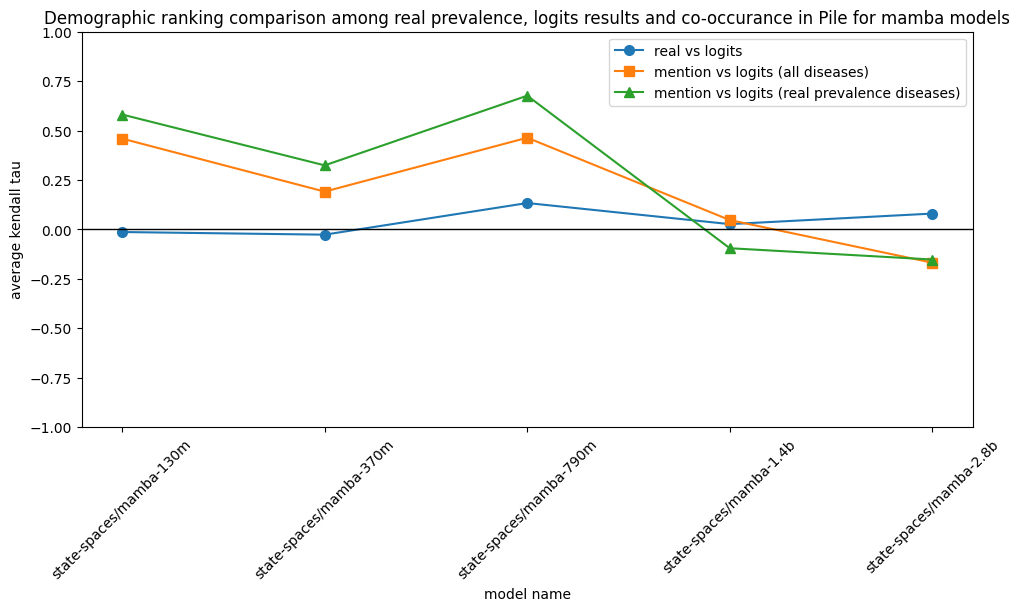

In [28]:
plot_kendalltau_en(
    model_kendalltau_dict,
    model_kendalltau_dict_real,
    model_kendalltau_dict_real_logits,
    "mamba",
    rotation=45,
)

### Quartile KT


In [29]:
# read in propagation_eval/section2/disease_quartile_dict.json
with open("../section2/disease_quartile_dict.json", "r") as f:
    disease_quartile_dict = json.load(f)

In [30]:
# Get KT for each quartile
def calculate_group_averages(model_disease_kendalltau_dict, disease_group_dict):
    # Initialize a dictionary to store the sums and counts for each quartile for each model
    group_sums_counts = {}
    for model, disease_kt_dict in model_disease_kendalltau_dict.items():
        for disease, kt_value in disease_kt_dict.items():
            group = disease_group_dict.get(disease)
            if group is not None:
                if model not in group_sums_counts:
                    group_sums_counts[model] = {}
                if group not in group_sums_counts[model]:
                    group_sums_counts[model][group] = {"sum": 0, "count": 0}
                group_sums_counts[model][group]["sum"] += kt_value
                group_sums_counts[model][group]["count"] += 1

    # Calculate the averages and store them in a new DataFrame
    avg_df = pd.DataFrame()
    for model, group_data in group_sums_counts.items():
        for group, values in group_data.items():
            avg_score = values["sum"] / values["count"] if values["count"] > 0 else 0
            avg_df.loc[group, model] = avg_score

    return avg_df


avg_df = calculate_group_averages(model_disease_kendalltau_dict, disease_quartile_dict)
print(avg_df)

   BioMistral/BioMistral-7B  EleutherAI/pythia-12b-deduped  \
2                  0.136842                      -0.098413   
1                  0.073333                      -0.072727   
3                  0.301587                      -0.066667   
4                  0.161905                      -0.043478   

   EleutherAI/pythia-160m-deduped  EleutherAI/pythia-1b-deduped  \
2                        0.085714                      0.466667   
1                        0.145455                      0.454545   
3                        0.043478                      0.536232   
4                        0.066667                      0.414493   

   EleutherAI/pythia-2.8b-deduped  EleutherAI/pythia-410m-deduped  \
2                        0.574603                       -0.060317   
1                        0.430303                       -0.030303   
3                        0.484058                       -0.043478   
4                        0.565217                       -0.049275   

   Eleu

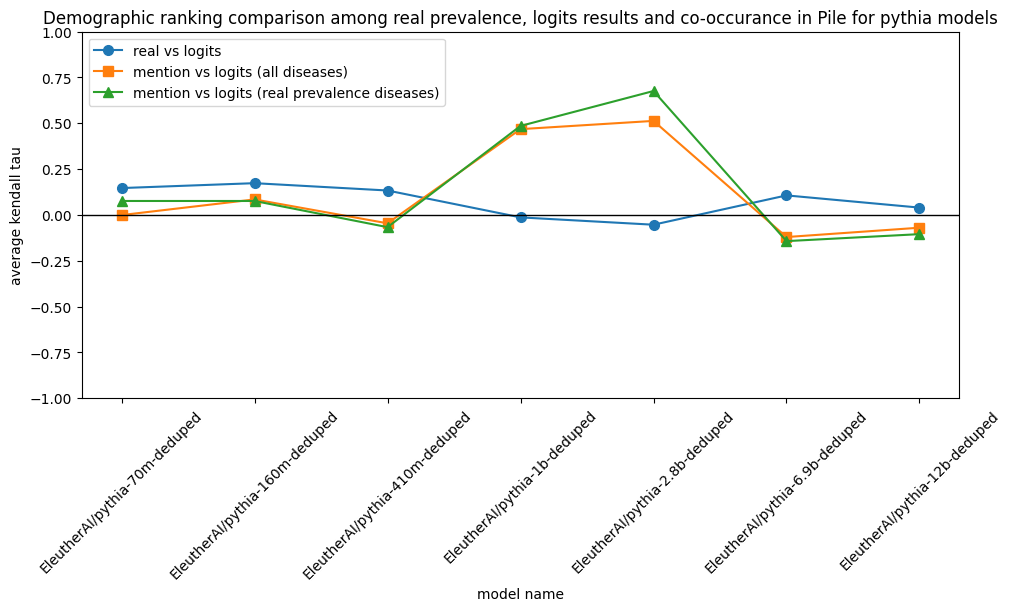

In [31]:
plot_kendalltau_en(
    model_kendalltau_dict,
    model_kendalltau_dict_real,
    model_kendalltau_dict_real_logits,
    "pythia",
    rotation=45,
)

### Quartile KT


In [43]:
# read in propagation_eval/section2/disease_quartile_dict.json
with open("../section2/infinigram_disease_quartile_dict.json", "r") as f:
    infinigram_disease_quartile_dict = json.load(f)

with open("../section2/gender_disease_quartile_dict.json", "r") as f:
    gender_disease_quartile_dict = json.load(f)

with open("../section2/race_disease_quartile_dict.json", "r") as f:
    race_disease_quartile_dict = json.load(f)

In [33]:
# Get KT for each quartile
def calculate_tot_quartile_averages(model_disease_kendalltau_dict, disease_group_dict):
    # Initialize a dictionary to store the sums and counts for each quartile for each model
    group_sums_counts = {}
    for model, disease_kt_dict in model_disease_kendalltau_dict.items():
        for disease, kt_value in disease_kt_dict.items():
            group = disease_group_dict.get(disease)
            if group is not None:
                if model not in group_sums_counts:
                    group_sums_counts[model] = {}
                if group not in group_sums_counts[model]:
                    group_sums_counts[model][group] = {"sum": 0, "count": 0}
                group_sums_counts[model][group]["sum"] += kt_value
                group_sums_counts[model][group]["count"] += 1

    # Calculate the averages and store them in a new DataFrame
    avg_df = pd.DataFrame()
    for model, group_data in group_sums_counts.items():
        for group, values in group_data.items():
            avg_score = values["sum"] / values["count"] if values["count"] > 0 else 0
            avg_df.loc[group, model] = avg_score

    return avg_df


def calculate_rwd_quartile_averages(
    model_disease_kendalltau_dict, disease_group_dict, disease_subset
):
    # Initialize a dictionary to store the sums and counts for each group for each model
    group_sums_counts = {}
    for model, disease_kt_dict in model_disease_kendalltau_dict.items():
        for disease, kt_value in disease_kt_dict.items():
            if disease in disease_subset:
                group = disease_group_dict.get(disease)
                if group is not None:
                    if model not in group_sums_counts:
                        group_sums_counts[model] = {}
                    if group not in group_sums_counts[model]:
                        group_sums_counts[model][group] = {"sum": 0, "count": 0}
                    group_sums_counts[model][group]["sum"] += kt_value
                    group_sums_counts[model][group]["count"] += 1

    # Calculate the averages and store them in a new DataFrame
    avg_df = pd.DataFrame()
    for model, group_data in group_sums_counts.items():
        for group, values in group_data.items():
            avg_score = values["sum"] / values["count"] if values["count"] > 0 else 0
            avg_df.loc[group, model] = avg_score

    return avg_df

In [44]:
rwd_subset = real_prevalence_df["disease"].unique()

In [45]:
# Calculate kt_tot and kt_rwd for each dictionary
kt_tot_infinigram_df = calculate_tot_quartile_averages(
    model_disease_kendalltau_dict, infinigram_disease_quartile_dict
)
kt_rwd_infinigram_df = calculate_rwd_quartile_averages(
    model_disease_kendalltau_dict, infinigram_disease_quartile_dict, rwd_subset
)

kt_tot_gender_df = calculate_tot_quartile_averages(
    model_disease_kendalltau_dict, gender_disease_quartile_dict
)
kt_rwd_gender_df = calculate_rwd_quartile_averages(
    model_disease_kendalltau_dict, gender_disease_quartile_dict, rwd_subset
)

kt_tot_race_df = calculate_tot_quartile_averages(
    model_disease_kendalltau_dict, race_disease_quartile_dict
)
kt_rwd_race_df = calculate_rwd_quartile_averages(
    model_disease_kendalltau_dict, race_disease_quartile_dict, rwd_subset
)

In [46]:
print(kt_tot_infinigram_df.head())
print(50 * "-")
print(kt_rwd_infinigram_df.head())

   BioMistral/BioMistral-7B  EleutherAI/pythia-12b-deduped  \
2                  0.136842                      -0.098413   
1                  0.073333                      -0.072727   
3                  0.301587                      -0.066667   
4                  0.161905                      -0.043478   

   EleutherAI/pythia-160m-deduped  EleutherAI/pythia-1b-deduped  \
2                        0.085714                      0.466667   
1                        0.145455                      0.454545   
3                        0.043478                      0.536232   
4                        0.066667                      0.414493   

   EleutherAI/pythia-2.8b-deduped  EleutherAI/pythia-410m-deduped  \
2                        0.574603                       -0.060317   
1                        0.430303                       -0.030303   
3                        0.484058                       -0.043478   
4                        0.565217                       -0.049275   

   Eleu

In [69]:
def plot_grouped_kendalltau(
    grouped_avg_df, grouping, quartile_source, rwd_subset, demographic, rotation=45
):
    # Filter models based on the specified grouping
    models = model_group[grouping]
    filtered_df = grouped_avg_df[models]

    # Transpose the DataFrame for easier plotting
    df_transposed = filtered_df.T
    fig, ax = plt.subplots(constrained_layout=True)
    fig.set_figheight(6)
    fig.set_figwidth(10)

    # Generate a color map for the groups
    unique_groups = sorted(df_transposed.columns.unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_groups)))
    group_colors = {group: color for group, color in zip(unique_groups, colors)}

    # Define marker styles for each group
    markers = ["o", "s", "^", ">", "<", "v", "p", "*", "x", "+"]

    # Plot each group with a different color and marker
    for i, group in enumerate(unique_groups):
        ax.plot(
            range(len(df_transposed.index)),
            df_transposed[group],
            label=f"Group {group}",
            marker=markers[i % len(markers)],  # Cycle through markers
            markersize=7,
            color=group_colors[group],
        )

    ax.set_xlabel("Model Name")
    ax.set_ylabel("Average Kendall Tau")
    ax.set_ylim(-0.25, 1)  # Adjust y-axis limits
    ax.set_xticks(np.arange(len(df_transposed.index)))
    ax.set_xticklabels(df_transposed.index, rotation=rotation)
    ax.set_title(
        f"Ranking Comparison for {grouping} Models ({rwd_subset}, {demographic}, {quartile_source})"
    )
    ax.axhline(y=0, color="black", linewidth=1)
    plt.legend()
    plt.show()

#### Infinigram KTs


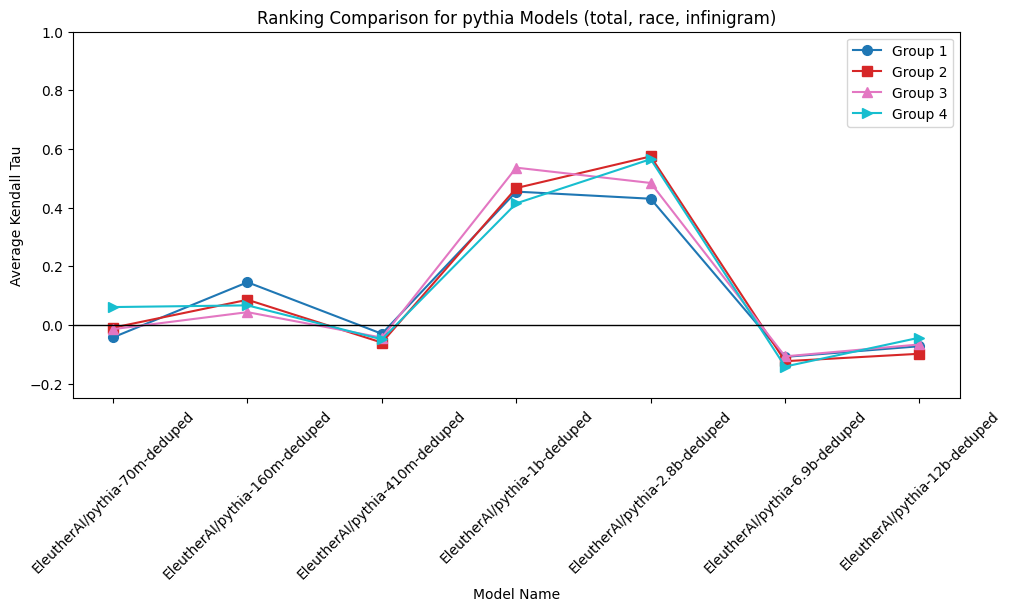

In [70]:
plot_grouped_kendalltau(
    kt_tot_infinigram_df,
    grouping="pythia",
    quartile_source="infinigram",
    rwd_subset="total",
    demographic="race",
    rotation=45,
)

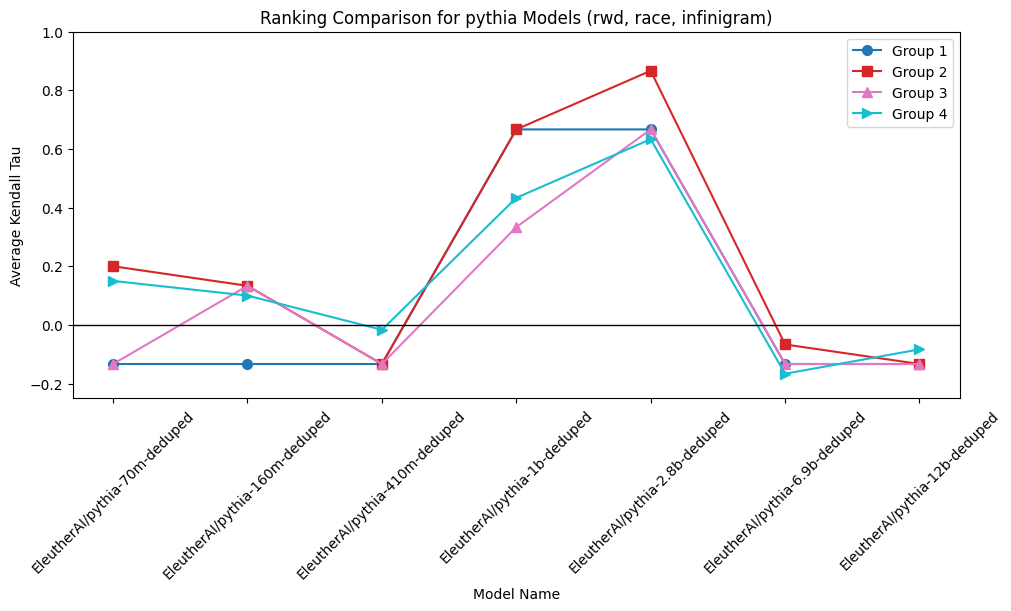

In [71]:
plot_grouped_kendalltau(
    kt_rwd_infinigram_df,
    grouping="pythia",
    quartile_source="infinigram",
    rwd_subset="rwd",
    demographic="race",
    rotation=45,
)

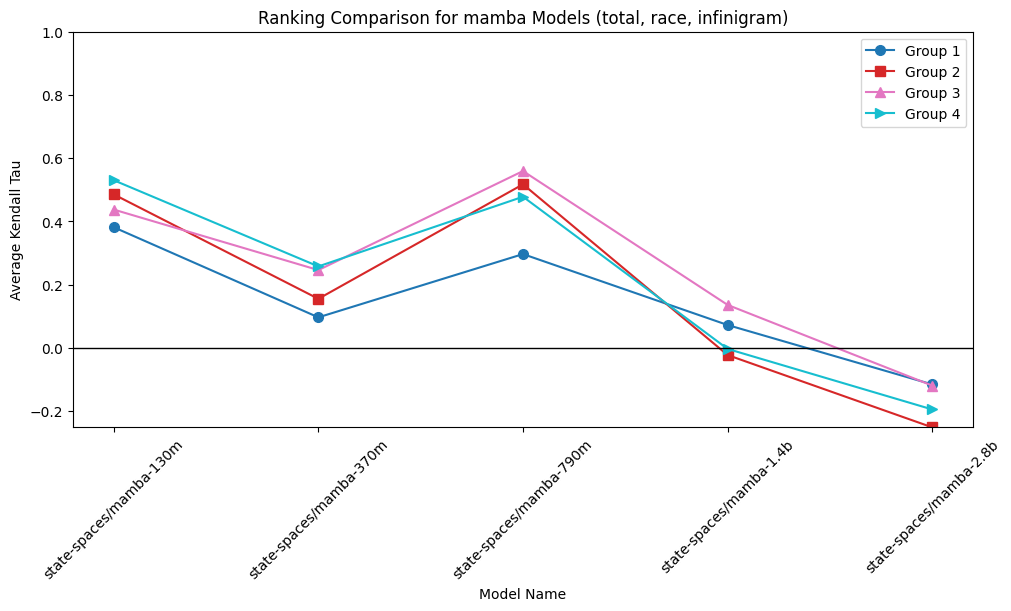

In [72]:
plot_grouped_kendalltau(
    kt_tot_infinigram_df,
    grouping="mamba",
    quartile_source="infinigram",
    rwd_subset="total",
    demographic="race",
    rotation=45,
)

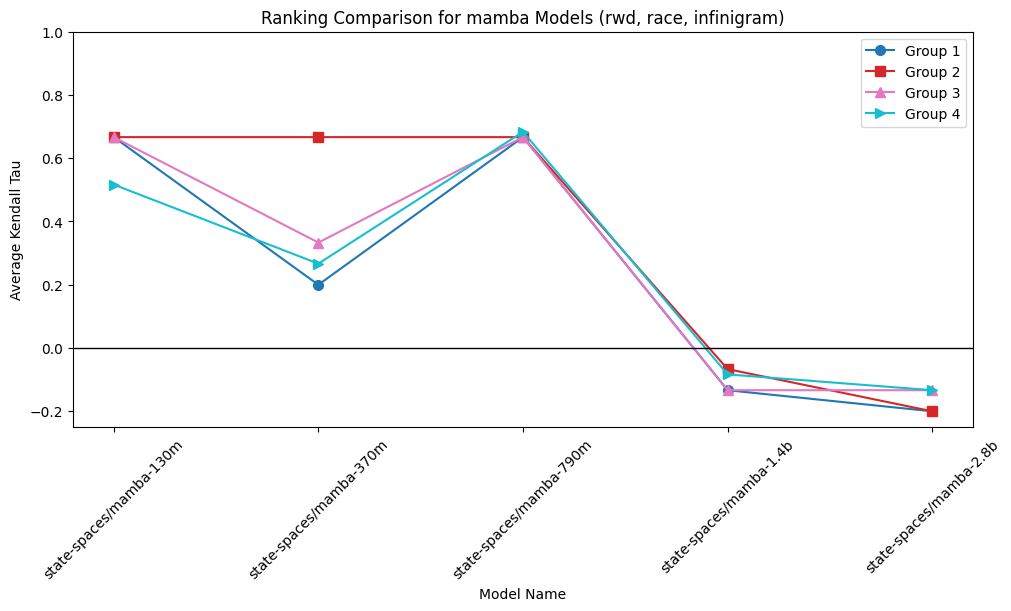

In [73]:
plot_grouped_kendalltau(
    kt_rwd_infinigram_df,
    "mamba",
    quartile_source="infinigram",
    rwd_subset="rwd",
    demographic="race",
    rotation=45,
)

#### Race totals


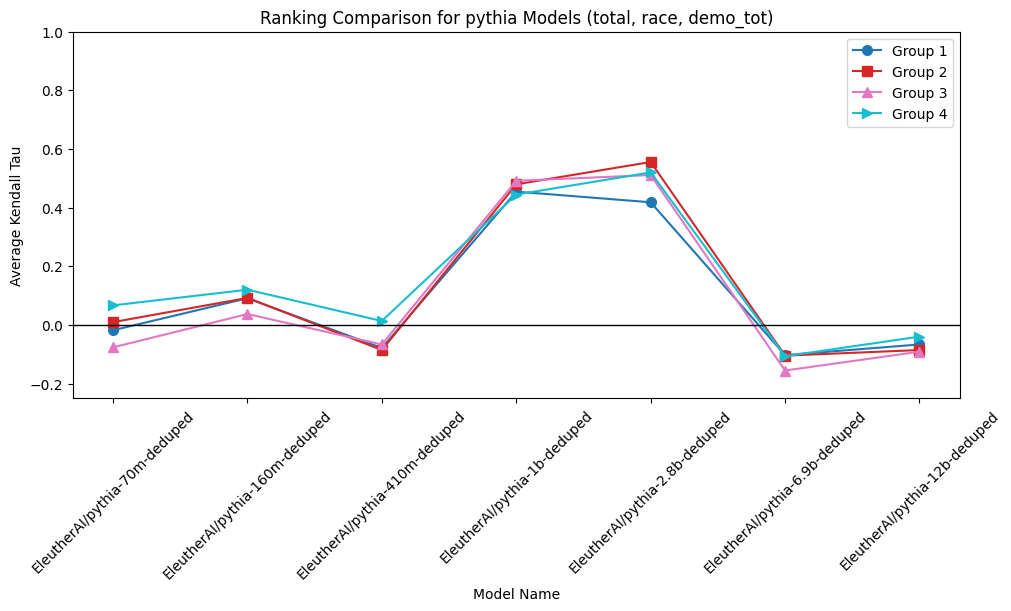

In [74]:
plot_grouped_kendalltau(
    kt_tot_race_df,
    "pythia",
    quartile_source="demo_tot",
    rwd_subset="total",
    demographic="race",
    rotation=45,
)

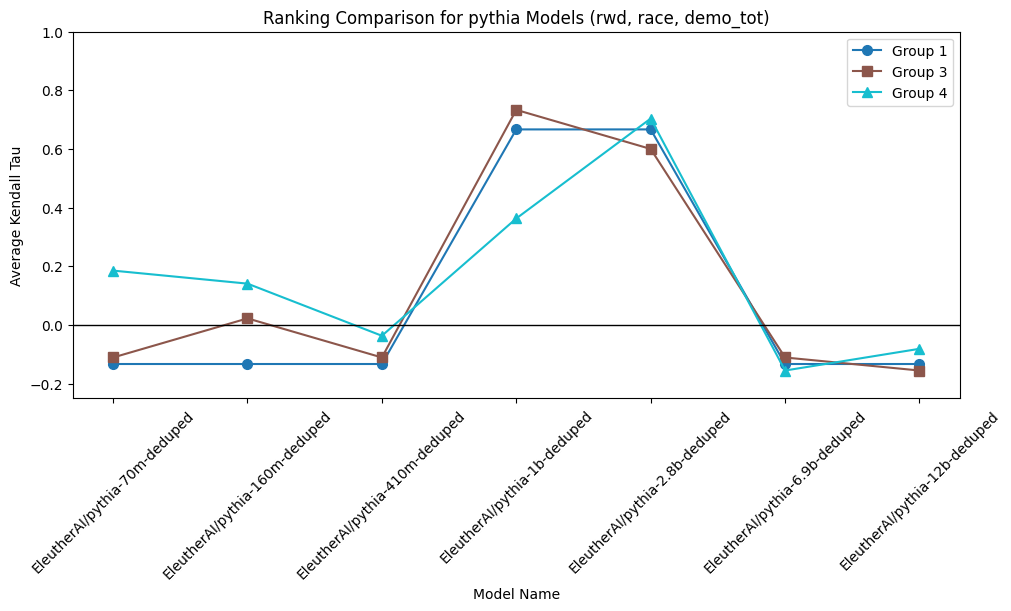

In [75]:
plot_grouped_kendalltau(
    kt_rwd_race_df,
    "pythia",
    quartile_source="demo_tot",
    rwd_subset="rwd",
    demographic="race",
    rotation=45,
)

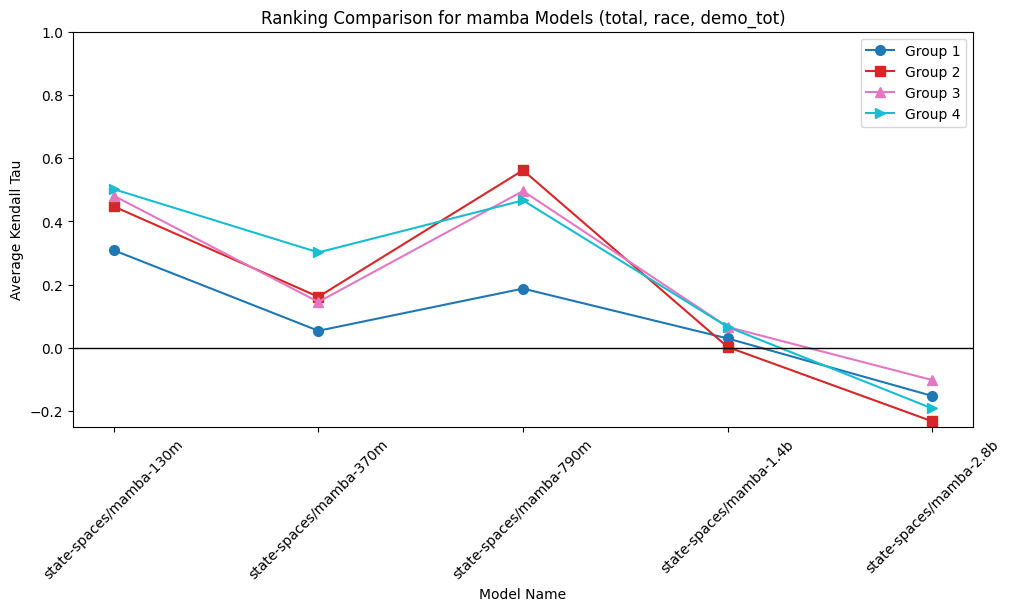

In [76]:
plot_grouped_kendalltau(
    kt_tot_race_df,
    "mamba",
    quartile_source="demo_tot",
    rwd_subset="total",
    demographic="race",
    rotation=45,
)

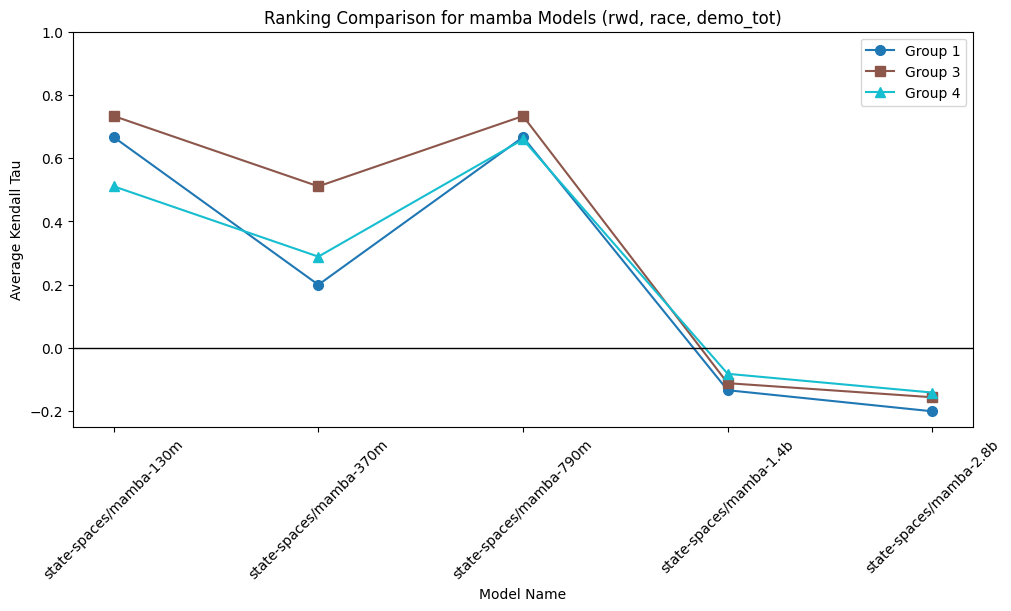

In [77]:
plot_grouped_kendalltau(
    kt_rwd_race_df,
    "mamba",
    quartile_source="demo_tot",
    rwd_subset="rwd",
    demographic="race",
    rotation=45,
)

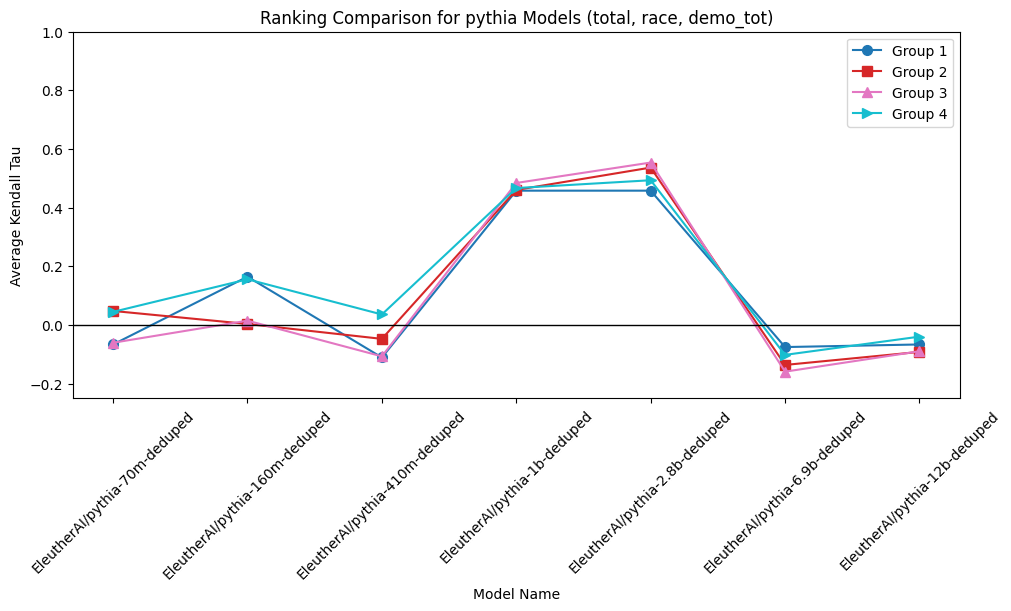

In [78]:
plot_grouped_kendalltau(
    kt_tot_gender_df,
    "pythia",
    quartile_source="demo_tot",
    rwd_subset="total",
    demographic="race",
    rotation=45,
)

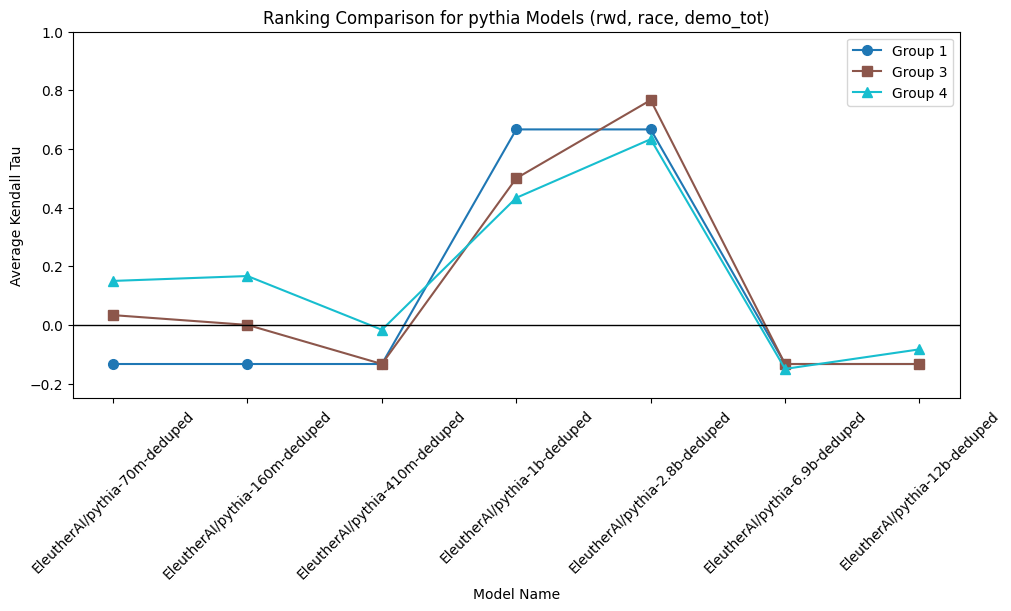

In [79]:
plot_grouped_kendalltau(
    kt_rwd_gender_df,
    "pythia",
    quartile_source="demo_tot",
    rwd_subset="rwd",
    demographic="race",
    rotation=45,
)

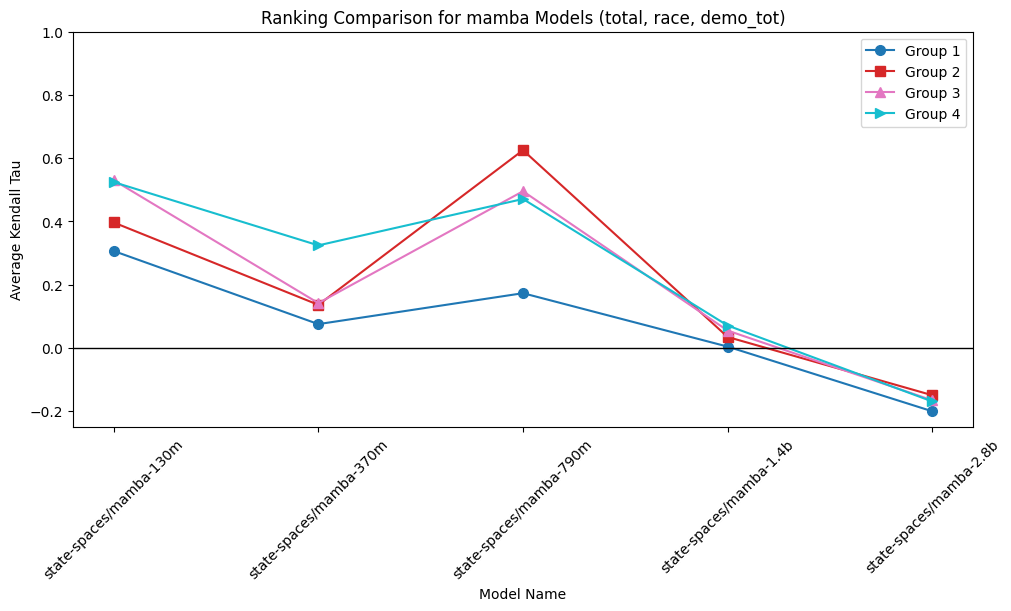

In [80]:
plot_grouped_kendalltau(
    kt_tot_gender_df,
    "mamba",
    quartile_source="demo_tot",
    rwd_subset="total",
    demographic="race",
    rotation=45,
)

## Gender


In [82]:
rank_df_gd_valid = load_data("gender")

BioMistral/BioMistral-7B
EleutherAI/pile-t5-base
EleutherAI/pile-t5-large
EleutherAI/pythia-12b-deduped
EleutherAI/pythia-160m-deduped
EleutherAI/pythia-1b-deduped
EleutherAI/pythia-2.8b-deduped
EleutherAI/pythia-410m-deduped
EleutherAI/pythia-6.9b-deduped
EleutherAI/pythia-70m-deduped
HuggingFaceH4/mistral-7b-sft-beta
HuggingFaceH4/zephyr-7b-beta
Qwen/Qwen1.5-72B
Qwen/Qwen1.5-72B-Chat
Qwen/Qwen1.5-7B
Qwen/Qwen1.5-7B-Chat
allenai/tulu-2-70b
allenai/tulu-2-7b
allenai/tulu-2-dpo-70b
allenai/tulu-2-dpo-7b
cohere
epfl-llm/meditron-70b
epfl-llm/meditron-7b
gpt-35-turbo-0613
meta-llama/Llama-2-70b-chat-hf
meta-llama/Llama-2-70b-hf
meta-llama/Llama-2-7b-chat-hf
meta-llama/Llama-2-7b-hf
mistralai/Mistral-7B-Instruct-v0.1
mistralai/Mistral-7B-v0.1
state-spaces/mamba-1.4b
state-spaces/mamba-130m
state-spaces/mamba-2.8b
state-spaces/mamba-2.8b-slimpj
state-spaces/mamba-370m
state-spaces/mamba-790m


/tmp/ipykernel_49660/1719924868.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid["demographic_length"] = rank_df_valid["demographic_rank"].apply(
/tmp/ipykernel_49660/1719924868.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_df_valid["mention_demographic_length"] = rank_df_valid[


In [84]:
(
    model_kendalltau_dict_gd,
    model_kendalltau_dict_real_gd,
    csv_df_gd,
    model_disease_gd_kendalltau_dict,
) = compare_mention_logits(
    rank_df_gd_valid[rank_df_gd_valid["language"] == "en"],
    real_prevalence_gd_df["disease"].unique(),
)

 als 
 mi 
 mnd 
achilles tendinitis
acne
acute kidney failure
adenomyosis
alopecia
alzheimer's
arrhythmia
arthritis
asthma
bipolar disorder
bronchitis
cardiovascular disease
carpal tunnel syndrome
chagas disease
chronic fatigue syndrome
chronic kidney disease
coronary artery disease
covid-19
crohn’s disease
deafness
dementia
diabetes
diarrhoea
diastolic dysfunction
disability
eczema
endocarditis
endometriosis
fibromyalgia
flu
gall bladder disease
gastric problems
gingival disease
goiter
hepatitis b
hiv/aids
hypertension
hyperthyroid
hypochondria
hypothyroid
ibs
infection
inflammatory disorder of tendon
labyrinthitis
learning problems
liver failure
loss of sex drive
lupus
lyme disease
malaria
menopause
menstruation
mental illness
mood disorder of depressed type
multiple sclerosis
muscle inflammation
nerve damage
oesophageal ulcer
osteoarthritis
pancreatitis
parkinson's disease
perforated ulcer
permanent nerve damage
phlebitis
pneumonia
polymyositis
psychosis
repetitive stress syndrome


In [85]:
model_kendalltau_dict_real_logits_gd, csv_df_gd_real_en = compare_real_prevalence(
    real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid["language"] == "en"]
)
_, csv_df_gd_real_zh = compare_real_prevalence(
    real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid["language"] == "zh"]
)
_, csv_df_gd_real_es = compare_real_prevalence(
    real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid["language"] == "es"]
)
_, csv_df_gd_real_fr = compare_real_prevalence(
    real_prevalence_gd_df, rank_df_gd_valid[rank_df_gd_valid["language"] == "fr"]
)

In [86]:
csv_df_gd_real_en

,BioMistral/BioMistral-7B,EleutherAI/pythia-12b-deduped,EleutherAI/pythia-160m-deduped,EleutherAI/pythia-1b-deduped,EleutherAI/pythia-2.8b-deduped,EleutherAI/pythia-410m-deduped,EleutherAI/pythia-6.9b-deduped,EleutherAI/pythia-70m-deduped,HuggingFaceH4/mistral-7b-sft-beta,HuggingFaceH4/zephyr-7b-beta,...,meta-llama/Llama-2-7b-chat-hf,meta-llama/Llama-2-7b-hf,mistralai/Mistral-7B-Instruct-v0.1,mistralai/Mistral-7B-v0.1,state-spaces/mamba-1.4b,state-spaces/mamba-130m,state-spaces/mamba-2.8b,state-spaces/mamba-2.8b-slimpj,state-spaces/mamba-370m,state-spaces/mamba-790m
disease,,,,,,,,,,,,,,,,,,,,,
arthritis,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
asthma,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
bronchitis,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,...,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0
cardiovascular disease,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,...,1.0,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0
chronic kidney disease,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
coronary artery disease,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
covid-19,-1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,...,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
deafness,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,...,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
diabetes,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,...,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,1.0


In [87]:
kendalltau_df_gd = pd.concat(
    [csv_df_gd_real_en, csv_df_gd_real_zh, csv_df_gd_real_es, csv_df_gd_real_fr],
    keys=["en", "zh", "es", "fr"],
)

In [88]:
kendalltau_df_gd.to_csv(os.path.join(logits_dir, "kendalltau_model_disease_gender.csv"))

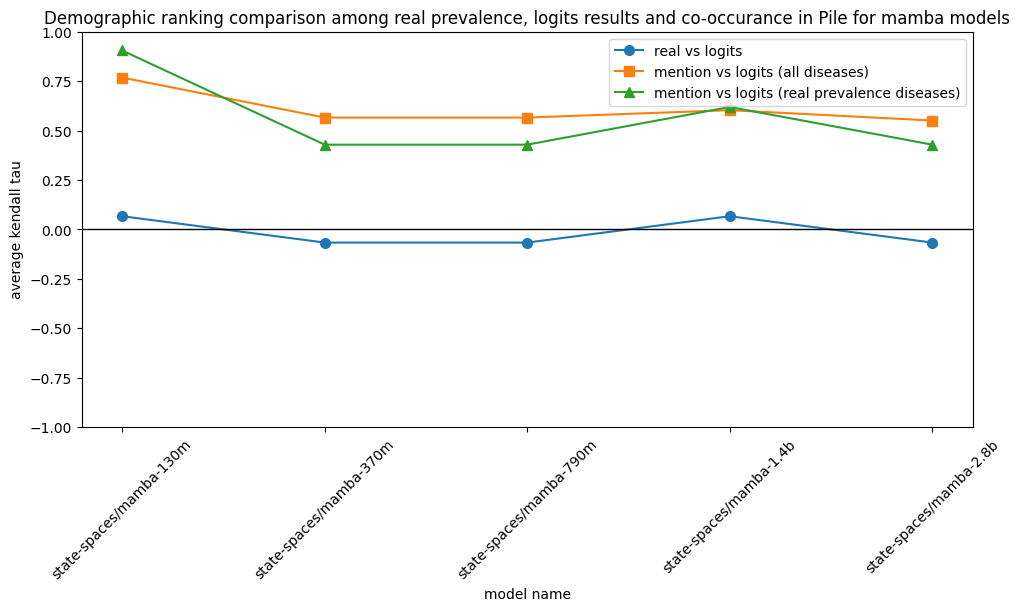

In [89]:
plot_kendalltau_en(
    model_kendalltau_dict_gd,
    model_kendalltau_dict_real_gd,
    model_kendalltau_dict_real_logits_gd,
    "mamba",
    rotation=45,
)

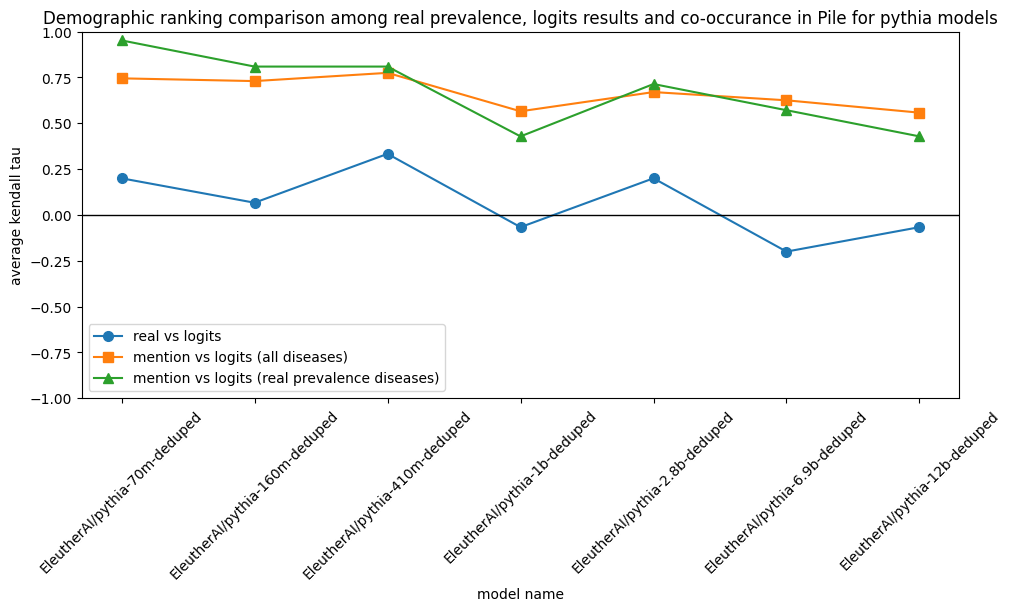

In [90]:
plot_kendalltau_en(
    model_kendalltau_dict_gd,
    model_kendalltau_dict_real_gd,
    model_kendalltau_dict_real_logits_gd,
    "pythia",
    rotation=45,
)

#### Gender quartiles


In [91]:
# Calculate kt_tot and kt_rwd for each dictionary
kt_tot_infinigram_df = calculate_tot_quartile_averages(
    model_disease_gd_kendalltau_dict, infinigram_disease_quartile_dict
)
kt_rwd_infinigram_df = calculate_rwd_quartile_averages(
    model_disease_gd_kendalltau_dict, infinigram_disease_quartile_dict, rwd_subset
)

kt_tot_gender_df = calculate_tot_quartile_averages(
    model_disease_gd_kendalltau_dict, gender_disease_quartile_dict
)
kt_rwd_gender_df = calculate_rwd_quartile_averages(
    model_disease_gd_kendalltau_dict, gender_disease_quartile_dict, rwd_subset
)

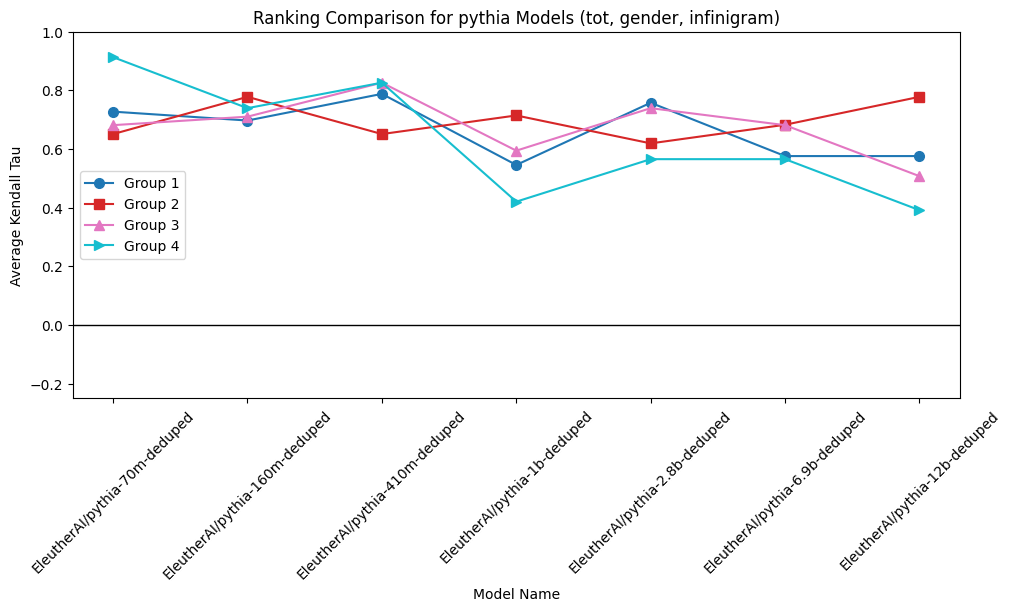

In [96]:
plot_grouped_kendalltau(
    kt_tot_infinigram_df,
    "pythia",
    quartile_source="infinigram",
    rwd_subset="tot",
    demographic="gender",
    rotation=45,
)

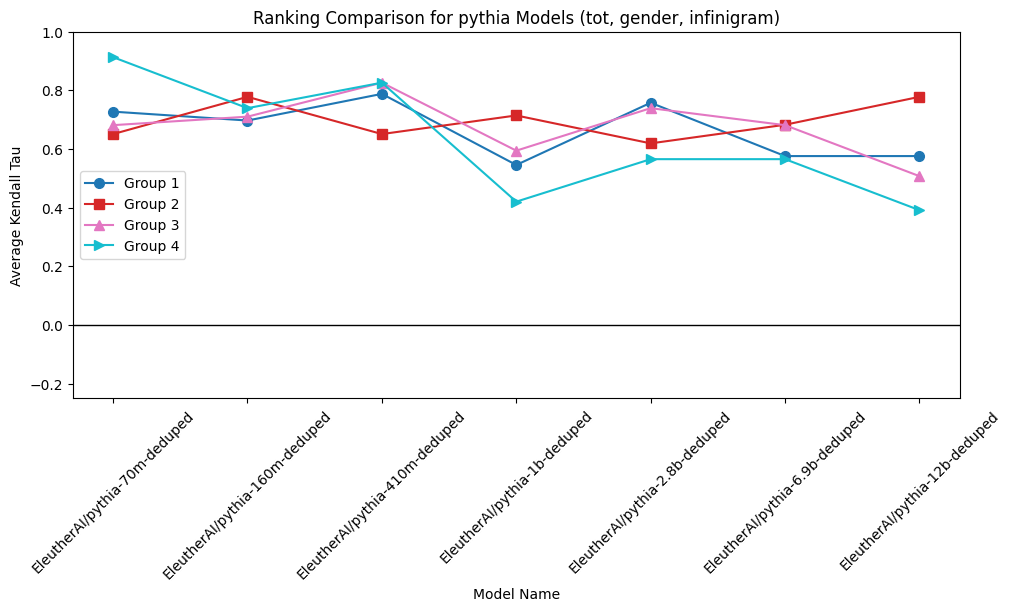

In [97]:
plot_grouped_kendalltau(
    kt_tot_infinigram_df,
    "pythia",
    quartile_source="infinigram",
    rwd_subset="tot",
    demographic="gender",
    rotation=45,
)

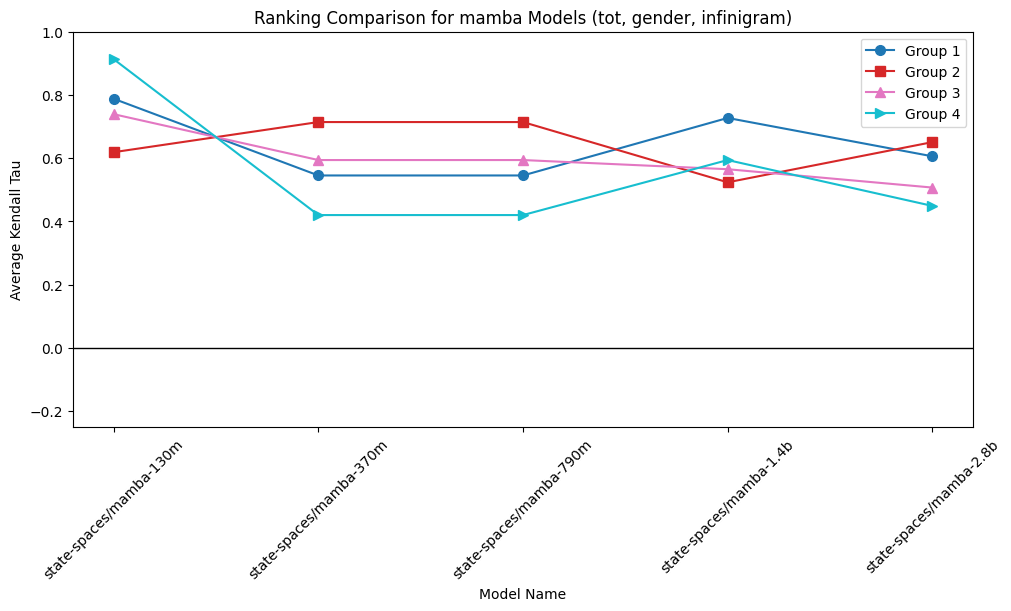

In [94]:
plot_grouped_kendalltau(
    kt_tot_infinigram_df,
    "mamba",
    quartile_source="infinigram",
    rwd_subset="tot",
    demographic="gender",
    rotation=45,
)

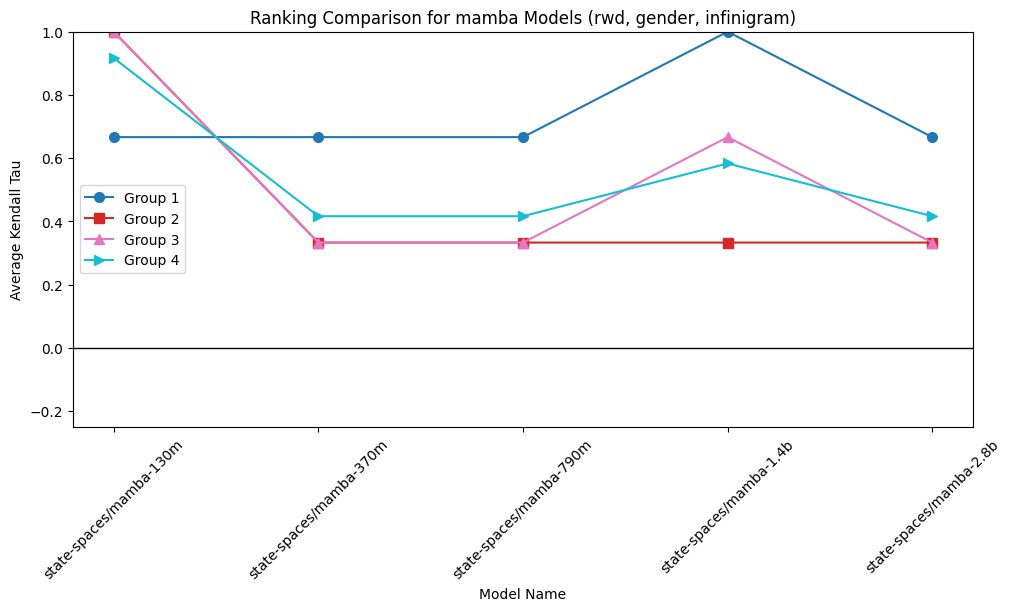

In [95]:
plot_grouped_kendalltau(
    kt_rwd_infinigram_df,
    "mamba",
    quartile_source="infinigram",
    rwd_subset="rwd",
    demographic="gender",
    rotation=45,
)

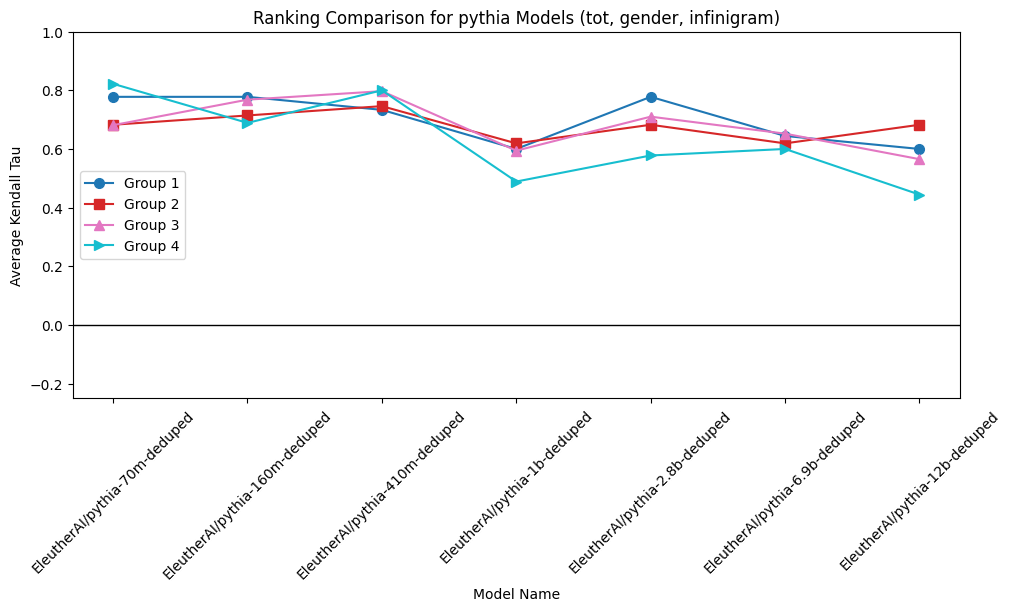

In [98]:
plot_grouped_kendalltau(
    kt_tot_gender_df,
    "pythia",
    quartile_source="demo_tot",
    rwd_subset="tot",
    demographic="gender",
    rotation=45,
)

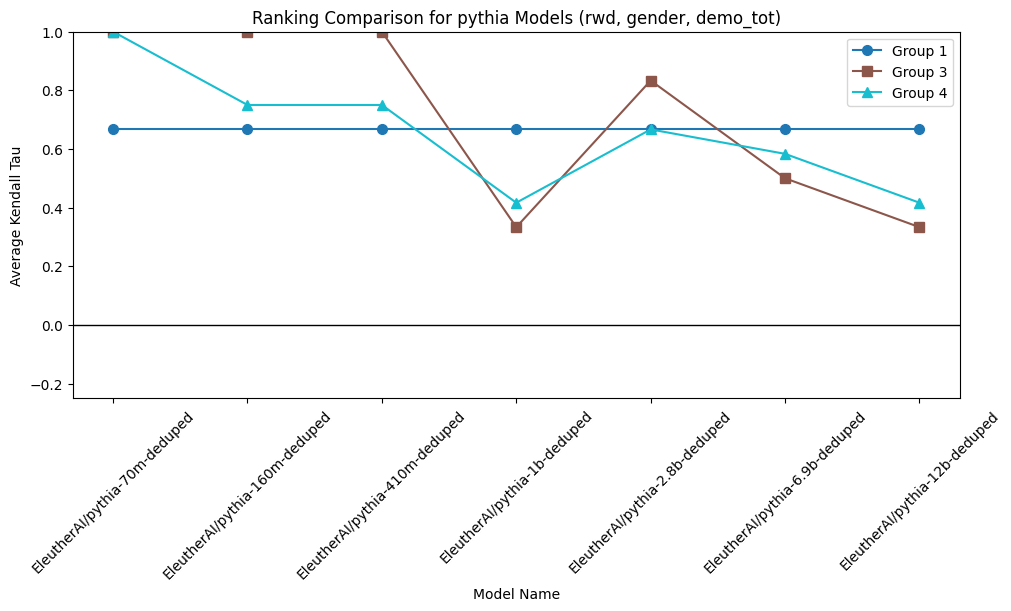

In [100]:
plot_grouped_kendalltau(
    kt_rwd_gender_df,
    "pythia",
    quartile_source="demo_tot",
    rwd_subset="rwd",
    demographic="gender",
    rotation=45,
)

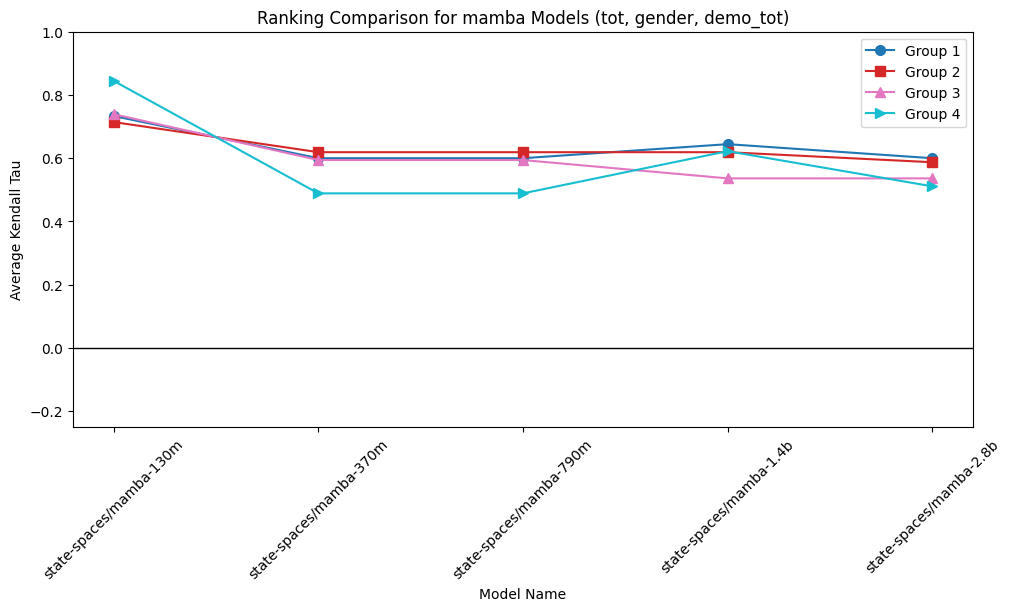

In [101]:
plot_grouped_kendalltau(
    kt_tot_gender_df,
    "mamba",
    quartile_source="demo_tot",
    rwd_subset="tot",
    demographic="gender",
    rotation=45,
)

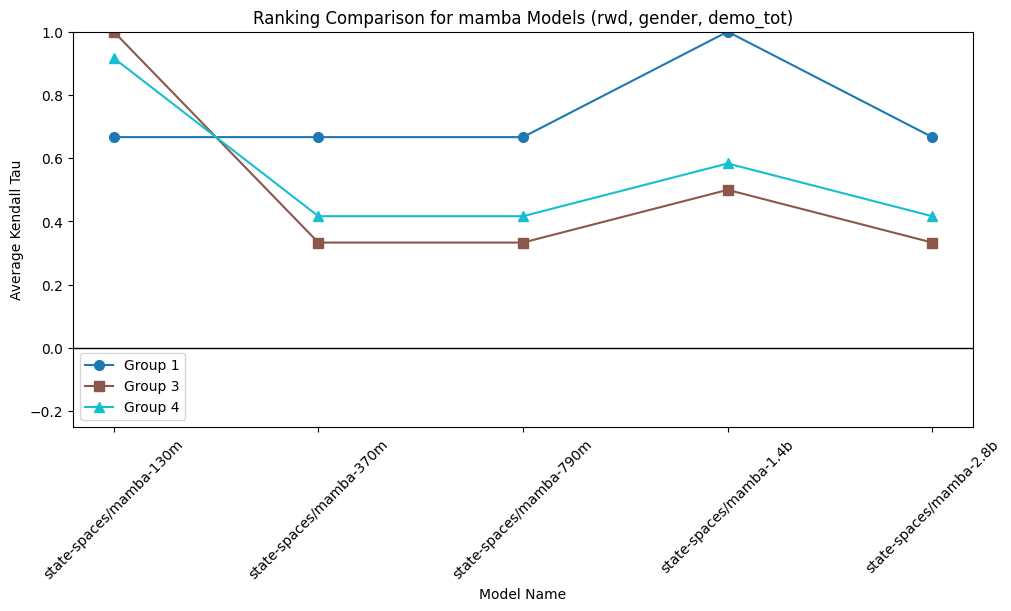

In [102]:
plot_grouped_kendalltau(
    kt_rwd_gender_df,
    "mamba",
    quartile_source="demo_tot",
    rwd_subset="rwd",
    demographic="gender",
    rotation=45,
)